In [59]:
import os, sys
import dotenv

import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm

sys.path.append(os.environ.get('PATH_OPENSKY'))
from user_eval import get_df_posts 
from news_outlet_eval import get_news_feed, get_posts_from_nos

dotenv.load_dotenv('.env')    
PATH_DATA = os.environ.get('PATH_OPENSKY') + os.environ.get('PATH_REL_DATA')
PATH_USER_POSTS = PATH_DATA + 'user_posts/'

PATH_RESULTS = os.environ.get('PATH_OPENSKY') + 'results/'
PATH_USER_REPLIES_NEWS = PATH_RESULTS + 'agg_user_replies_news_2.csv'
PATH_USER_REPLIES_NEWS_POSTS = PATH_RESULTS + 'agg_user_replies_news_posts_2.csv'

PATH_FEED_POSTS = PATH_DATA + 'feed_posts/'

df = pd.read_csv(PATH_USER_REPLIES_NEWS_POSTS)

/tmp/ipykernel_278189/345954859.py:23: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH_USER_REPLIES_NEWS_POSTS)


In [60]:
df

,post_id,user_id,instance,date,text,langs,like_count,reply_count,repost_count,reply_to,replied_author,thread_root,thread_root_author,repost_from,reposted_author,quotes,quoted_author,labels,sent_label,sent_score
0,10657080,284413,bsky.social,2024-01-14 08:03:00,let’s hope his expands ten fold 💪💪,['eng'],0,0,0,10657081.0,15717.0,10657081.0,15717.0,NaN,NaN,NaN,NaN,NaN,2.0,0.945
1,10657084,284413,bsky.social,2024-01-12 22:12:00,"yes, we can do this! 💪",['eng'],3,0,0,5595208.0,2486.0,5595208.0,2486.0,NaN,NaN,NaN,NaN,NaN,2.0,0.956
2,10657085,284413,bsky.social,2024-01-11 14:19:00,"in other words, “as long as it takes” it refer...",['eng'],0,1,0,10657086.0,12030.0,10657086.0,12030.0,NaN,NaN,NaN,NaN,NaN,1.0,0.583
3,10657096,284413,bsky.social,2024-01-08 14:10:00,i’ll believe it when i see the weapons in Ukra...,['eng'],0,0,0,10657097.0,15717.0,10657097.0,15717.0,NaN,NaN,NaN,NaN,NaN,1.0,0.509
4,10657117,284413,bsky.social,2024-01-05 09:22:00,Expect the world to become way way worse. If a...,['eng'],1,0,0,5271912.0,15717.0,5271912.0,15717.0,NaN,NaN,NaN,NaN,NaN,0.0,0.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36816,171050451,141248,bsky.social,2024-03-09 13:47:00,La preuve qu'ils sont antidémocratiques. \nPer...,"['eng', 'fra']",4,0,0,5550653.0,4890.0,5550653.0,4890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36817,105014318,92560,bsky.social,2024-03-08 01:59:00,What a complete abdication of good journalism ...,['eng'],0,0,0,698597.0,9.0,698597.0,9.0,NaN,NaN,NaN,NaN,NaN,0.0,0.790
36818,105014322,92560,bsky.social,2024-03-07 22:16:00,Trump and Biden are at par with age...exactly ...,['eng'],4,0,0,127576.0,379.0,127576.0,379.0,NaN,NaN,NaN,NaN,NaN,0.0,0.867
36819,105014501,92560,bsky.social,2024-01-05 08:08:00,Because doctors are literally refusing to pres...,['eng'],1,0,0,145919.0,379.0,145919.0,379.0,NaN,NaN,NaN,NaN,NaN,0.0,0.882


In [76]:
bm_first_depth = (df.reply_to == df.thread_root)
bm_first_depth.sum()

np.int64(22361)

In [83]:
df[bm_first_depth].groupby('thread_root').agg({'reply_to': 'count'}).sort_values('reply_to', ascending=False).hist()

,reply_to
thread_root,
83904.0,197
126715.0,195
26242.0,193
134087.0,153
158825.0,130
...,...
218513913.0,1
218462054.0,1
217879496.0,1


In [61]:
df.thread_root_author.nunique()

70

In [62]:
df.groupby('thread_root_author').size().sort_values(ascending=False)

thread_root_author
379.0       11536
319.0        7818
9.0          2872
9487.0       2222
626.0        1840
            ...  
11193.0         2
63352.0         2
283960.0        2
196964.0        1
296757.0        1
Length: 70, dtype: int64

In [63]:
import matplotlib.pyplot as plt

# Set 'date' as the index
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.set_index('date', inplace=True)

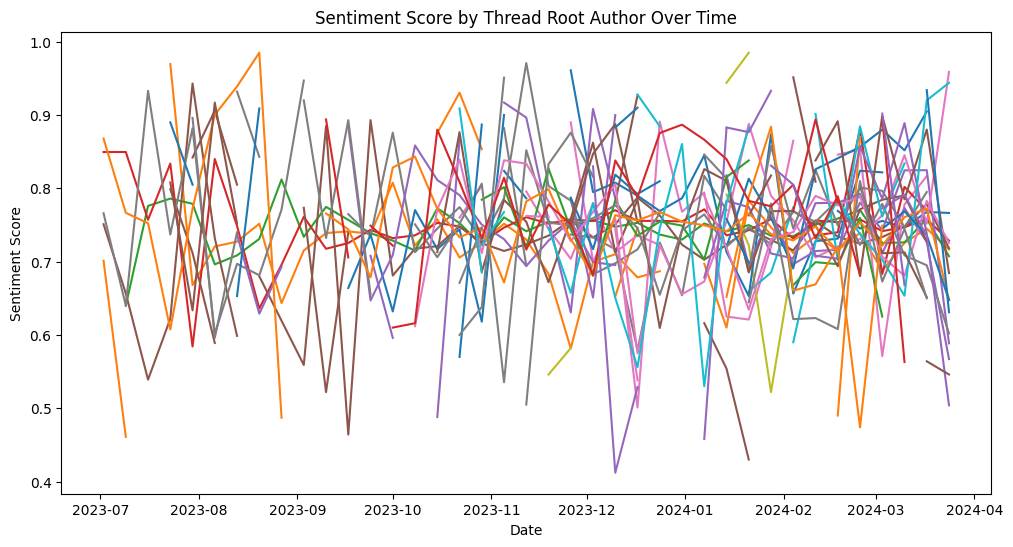

In [75]:
# Group by 'thread_root_author' and resample by time (e.g., monthly)

start_date = '2023-01-01'
end_date = '2024-12-31'

df.sort_index(inplace=True)

# Filter the DataFrame to only include rows within the date range
df_filtered = df.loc[start_date:end_date]

df_resampled = df_filtered.groupby('thread_root_author').resample('W').agg({'sent_score': 'mean'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
for author in df_resampled['thread_root_author'].unique():
    author_data = df_resampled[df_resampled['thread_root_author'] == author]
    plt.plot(author_data['date'], author_data['sent_score'], label=author)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score by Thread Root Author Over Time')
#plt.xaxis.set_l
#plt.legend(title='Thread Root Author')
plt.show()

/tmp/ipykernel_278189/3592615404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['thread_root'], inplace=True)
/tmp/ipykernel_278189/3592615404.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['sent_score'], inplace=True)
/tmp/ipykernel_278189/3592615404.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_filtered.groupby('thread_root').resample('T').agg({'sent_score': 'mean'}).reset_index()


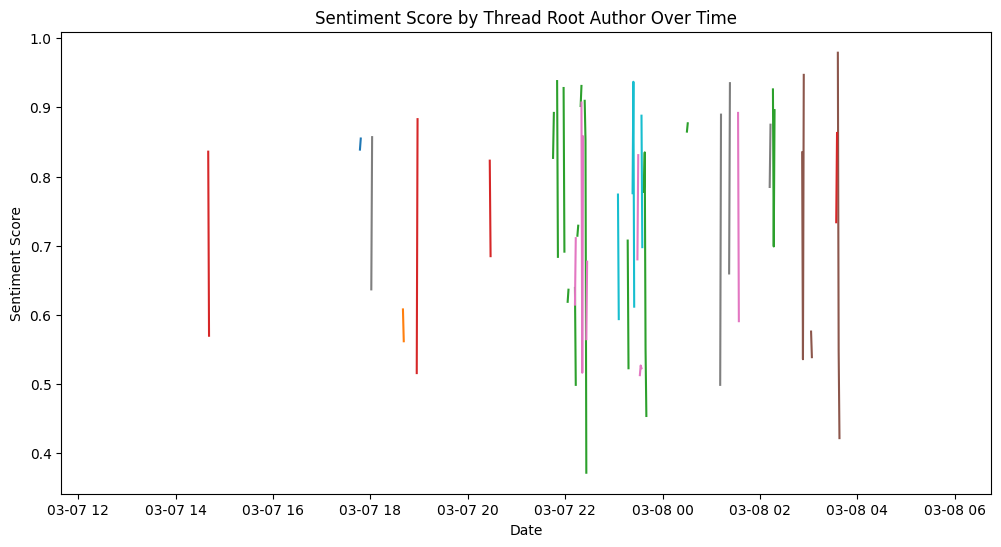

In [73]:
# Group by 'thread_root_author' and resample by time (e.g., monthly)

start_date = '2024-03-07 12:00'
end_date = '2024-03-08 6:00'

df.sort_index(inplace=True)

# Filter the DataFrame to only include rows within the date range
df_filtered = df.loc[start_date:end_date]
df_filtered.dropna(subset=['thread_root'], inplace=True)
df_filtered.dropna(subset=['sent_score'], inplace=True)

df_resampled = df_filtered.groupby('thread_root').resample('T').agg({'sent_score': 'mean'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
for root_post in df_resampled['thread_root'].unique():
    root_post_data = df_resampled[df_resampled['thread_root'] == root_post]
    plt.plot(root_post_data['date'], root_post_data['sent_score'], label=root_post)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score by Thread Root Author Over Time')
#plt.xaxis.set_l
#plt.legend(title='Thread Root Author')
plt.show()

In [86]:
df_news = get_news_feed()
df_news.set_index('post_id')

,user_id,instance,date,text,langs,like_count,reply_count,repost_count,reply_to,replied_author,thread_root,thread_root_author,quotes,quoted_author,labels
post_id,,,,,,,,,,,,,,,
3517724,27155,com,2023-10-20 11:25:00,📍 Welcome to 📰 News! Please hit Like ❤️ above ...,[eng],2799,46,104,NaN,NaN,NaN,NaN,None,None,None
3517724,27155,com,2023-10-20 11:25:00,📍 Welcome to 📰 News! Please hit Like ❤️ above ...,[eng],2799,46,104,NaN,NaN,NaN,NaN,None,None,None
3517724,27155,com,2023-10-20 11:25:00,📍 Welcome to 📰 News! Please hit Like ❤️ above ...,[eng],2799,46,104,NaN,NaN,NaN,NaN,None,None,None
73976085,12030,com,2024-03-14 06:30:00,The low end consumer is still struggling\n\nht...,None,0,0,0,NaN,NaN,NaN,NaN,None,None,None
3517724,27155,com,2023-10-20 11:25:00,📍 Welcome to 📰 News! Please hit Like ❤️ above ...,[eng],2799,46,104,NaN,NaN,NaN,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70869659,319,com,2023-06-27 13:00:00,Tuesday briefing:\n\n- Vladimir Putin spoke fo...,None,18,0,3,NaN,NaN,NaN,NaN,None,None,None
2974,319,com,2023-06-26 15:29:00,"no for real, no paywall on our articles until ...",None,78,0,50,1233314.0,319.0,1233314.0,319.0,None,None,None
44325423,319,com,2023-06-21 18:43:00,Florida Gov. Ron DeSantis’s wealthy donors and...,None,19,6,6,NaN,NaN,NaN,NaN,None,None,None


In [88]:
df_news.loc[df_news['user_id'] == 379]

,post_id,user_id,instance,date,text,langs,like_count,reply_count,repost_count,reply_to,replied_author,thread_root,thread_root_author,quotes,quoted_author,labels
7,3753243,379,com,2024-03-18 23:41:00,"A conservative social media influencer, Isabel...",[eng],153,12,26,NaN,NaN,NaN,NaN,None,None,None
13,7955093,379,com,2024-03-18 23:16:00,"An engine fire, a tire lost shortly after take...",[eng],50,3,14,NaN,NaN,NaN,NaN,None,None,None
16,697660,379,com,2024-03-18 23:06:00,Donald Trump accused Jewish voters of hating t...,[eng],55,16,18,NaN,NaN,NaN,NaN,None,None,None
24,5425802,379,com,2024-03-18 22:31:00,A second man has been charged in connection wi...,[eng],35,1,3,NaN,NaN,NaN,NaN,None,None,None
37,23172259,379,com,2024-03-18 21:48:00,Of all the classroom visits the author Tommy O...,[eng],24,0,4,NaN,NaN,NaN,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41774,23172811,379,com,2023-08-04 18:14:00,"Thousands of beagles, bred for research, were ...",[eng],51,3,10,NaN,NaN,NaN,NaN,None,None,None
41843,14991203,379,com,2023-08-03 20:37:00,Breaking News: Donald Trump pleaded not guilty...,[eng],45,1,16,NaN,NaN,NaN,NaN,None,None,None
41966,13790023,379,com,2023-07-25 18:16:00,Breaking News: The Education Department opened...,[eng],71,0,27,NaN,NaN,NaN,NaN,None,None,None
42017,195973,379,com,2023-07-13 22:32:00,Breaking News: A WHO panel called the widely u...,[eng],12,1,7,NaN,NaN,NaN,NaN,None,None,None
